In [1]:
import os
import sys

if "google.colab" in sys.modules:
    !git clone https://github.com/Sneha73685/f1-tyre-strategy-colab.git
    %cd f1-tyre-strategy-colab
    !pip install -r requirements.txt

In [2]:
import numpy as np
np.random.seed(42)

In [3]:
!pwd
!ls

/Users/sneha/Developer/F1 Project/f1-tyre-strategy-colab
Agreement Between Degradation Model and Full Race Simulation.png
Data-Driven Driver Degradation Tendencies (2020–2024).png
Monte Carlo Strategy Comparison Across Compounds.png
Monte Carlo Strategy Cost with Uncertainty.png
One-Stop Strategy Cost (Medium Compound).png
One-Stop Strategy Cost by Compound.png
README.md
Tyre Degradation by Compound.png
Tyre Degradation vs Tyre Life.png
data
monte_carlo_strategy_summary.csv
outputs
requirements.txt
src
tyre-degradation-simulation layer-1.ipynb
tyre-degradation-simulation-code.ipynb
tyre-degradation-simulation.ipynb
venv


In [4]:
import os

os.makedirs("outputs", exist_ok=True)

In [5]:
FAST_MODE = True
N_SIM = 500 if FAST_MODE else 3000

In [6]:
FAST_MODE = True

if FAST_MODE:
    N_SIM_SMALL = 200
    N_SIM_MED = 300
    N_SIM_FULL = 500
else:
    N_SIM_SMALL = 1000
    N_SIM_MED = 2000
    N_SIM_FULL = 5000

In [7]:
TRACK_DEGRADATION_FACTORS = {
    # Low degradation / street or smooth surface
    "Monaco": 0.7,
    "Baku": 0.8,
    "Monza": 0.8,

    # Medium degradation
    "Silverstone": 1.0,
    "Mexico": 1.0,
    "AbuDhabi": 1.0,

    # Medium-high degradation
    "Barcelona": 1.1,
    "Singapore": 1.1,

    # High degradation
    "Spa": 1.2,
    "Suzuka": 1.2,

    # Very high degradation
    "Bahrain": 1.3,
    "Hungaroring": 1.3
}

In [8]:
DRIVER_STYLE_FACTORS = {
    "Aggressive": 1.1,
    "Balanced": 1.0,
    "TyreSaver": 0.9
}

In [9]:
import numpy as np
np.random.seed(42)

In [10]:
import sys
sys.path.append("src")

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_loader import load_race_data
from degradation import TyreDegradationModel
from strategy import one_stop_strategy, two_stop_strategy

In [12]:
def create_track_aware_model(compound, track):
    model = TyreDegradationModel(compound=compound)
    track_factor = TRACK_DEGRADATION_FACTORS.get(track, 1.0)
    model.alpha *= track_factor
    return model

In [13]:
race_data = load_race_data("data/processed/race_data.csv")
race_data.head()

,lap,tyre_life
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


In [14]:
import inspect
from degradation import TyreDegradationModel
print(inspect.signature(TyreDegradationModel.predict))

(self, tyre_life)


In [15]:
model = TyreDegradationModel(compound="Medium")
model.fit(race_data)

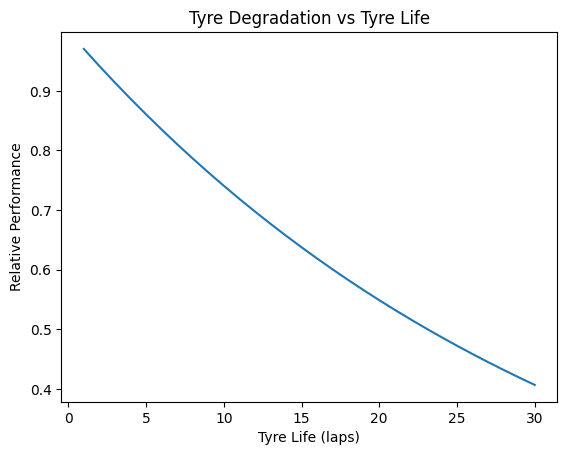

In [16]:
tyre_life = np.arange(1, 31)
curve = model.predict(tyre_life)

plt.figure()
plt.plot(tyre_life, curve)
plt.xlabel("Tyre Life (laps)")
plt.ylabel("Relative Performance")
plt.title("Tyre Degradation vs Tyre Life")
plt.show()

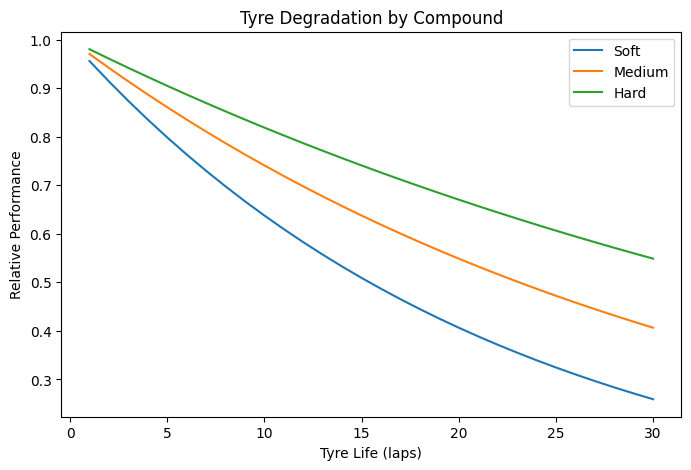

In [17]:
tyre_life = np.arange(1, 31)

compounds = ["Soft", "Medium", "Hard"]

plt.figure(figsize=(8,5))

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    curve = model.predict(tyre_life)
    plt.plot(tyre_life, curve, label=compound)

plt.xlabel("Tyre Life (laps)")
plt.ylabel("Relative Performance")
plt.title("Tyre Degradation by Compound")
plt.legend()
plt.show()

In [18]:
from strategy import one_stop_strategy

total_laps = 70
model = TyreDegradationModel(compound="Medium")

pit_range = range(15, 41)
one_stop_results = []

for pit in pit_range:
    cost = one_stop_strategy(model, total_laps, pit)
    one_stop_results.append((pit, cost))

one_stop_df = pd.DataFrame(one_stop_results, columns=["Pit Lap", "Total Degradation Cost"])
one_stop_df.head()

,Pit Lap,Total Degradation Cost
0,15,31.571504
1,16,31.144770
2,17,30.742174
3,18,30.363351
4,19,30.007962


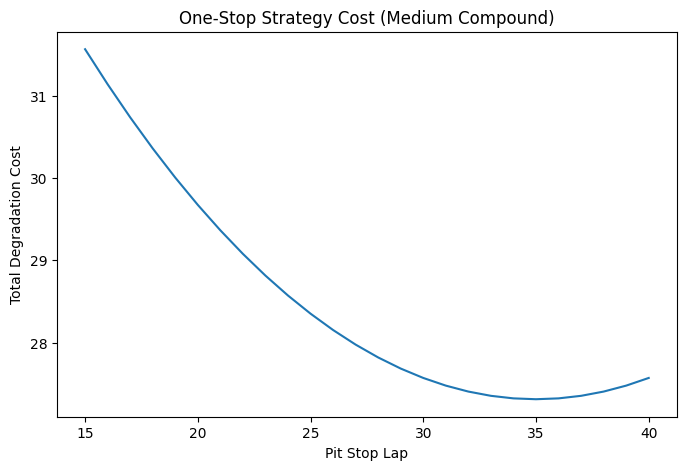

In [19]:
plt.figure(figsize=(8,5))
plt.plot(one_stop_df["Pit Lap"], one_stop_df["Total Degradation Cost"])
plt.xlabel("Pit Stop Lap")
plt.ylabel("Total Degradation Cost")
plt.title("One-Stop Strategy Cost (Medium Compound)")
plt.show()

In [20]:
from strategy import two_stop_strategy

two_stop_results = []

for pit1 in range(15, 30):
    for pit2 in range(pit1 + 10, 50):
        cost = two_stop_strategy(model, total_laps, pit1, pit2)
        two_stop_results.append((pit1, pit2, cost))

two_stop_df = pd.DataFrame(
    two_stop_results,
    columns=["Pit 1", "Pit 2", "Total Degradation Cost"]
)

two_stop_df.sort_values("Total Degradation Cost").head()

,Pit 1,Pit 2,Total Degradation Cost
185,23,46,20.414752
186,23,47,20.414752
202,24,47,20.414752
203,24,48,20.429576
201,24,46,20.429576


In [21]:
best_one_stop = one_stop_df.loc[
    one_stop_df["Total Degradation Cost"].idxmin()
]

best_one_stop

Pit Lap                   35.000000
Total Degradation Cost    27.309329
Name: 20, dtype: float64

In [22]:
best_two_stop = two_stop_df.loc[
    two_stop_df["Total Degradation Cost"].idxmin()
]

best_two_stop

Pit 1                     23.000000
Pit 2                     46.000000
Total Degradation Cost    20.414752
Name: 185, dtype: float64

In [23]:
comparison_df = pd.DataFrame([
    ["One-stop", best_one_stop["Total Degradation Cost"]],
    ["Two-stop", best_two_stop["Total Degradation Cost"]],
], columns=["Strategy", "Total Degradation Cost"])

comparison_df

,Strategy,Total Degradation Cost
0,One-stop,27.309329
1,Two-stop,20.414752


In [24]:
compounds = ["Soft", "Medium", "Hard"]
total_laps = 70
pit_range = range(15, 41)

compound_one_stop_results = []

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    
    for pit in pit_range:
        cost = one_stop_strategy(model, total_laps, pit)
        compound_one_stop_results.append(
            (compound, pit, cost)
        )

compound_one_stop_df = pd.DataFrame(
    compound_one_stop_results,
    columns=["Compound", "Pit Lap", "Total Degradation Cost"]
)

compound_one_stop_df.head()

,Compound,Pit Lap,Total Degradation Cost
0,Soft,15,39.438497
1,Soft,16,39.035908
2,Soft,17,38.658610
3,Soft,18,38.305841
4,Soft,19,37.976886


In [25]:
best_one_stop_by_compound = (
    compound_one_stop_df
    .loc[compound_one_stop_df.groupby("Compound")["Total Degradation Cost"].idxmin()]
)

best_one_stop_by_compound

,Compound,Pit Lap,Total Degradation Cost
72,Hard,35,20.160267
46,Medium,35,27.309329
20,Soft,35,35.542936


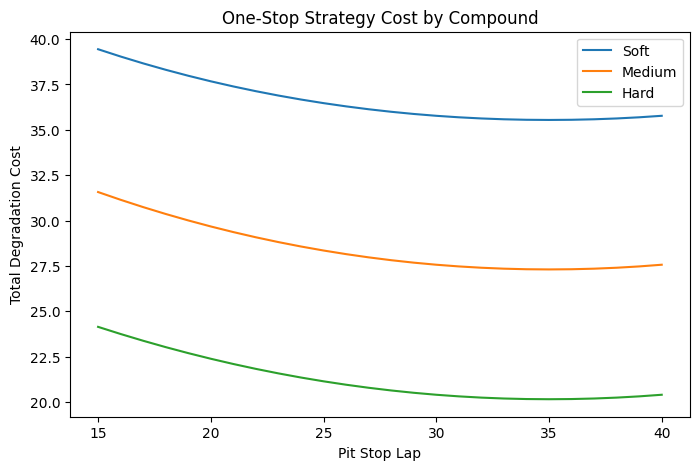

In [26]:
plt.figure(figsize=(8,5))

for compound in compounds:
    subset = compound_one_stop_df[
        compound_one_stop_df["Compound"] == compound
    ]
    plt.plot(
        subset["Pit Lap"],
        subset["Total Degradation Cost"],
        label=compound
    )

plt.xlabel("Pit Stop Lap")
plt.ylabel("Total Degradation Cost")
plt.title("One-Stop Strategy Cost by Compound")
plt.legend()
plt.show()

In [27]:
compound_two_stop_results = []

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    
    for pit1 in range(15, 30):
        for pit2 in range(pit1 + 10, 50):
            cost = two_stop_strategy(model, total_laps, pit1, pit2)
            compound_two_stop_results.append(
                (compound, pit1, pit2, cost)
            )

compound_two_stop_df = pd.DataFrame(
    compound_two_stop_results,
    columns=["Compound", "Pit 1", "Pit 2", "Total Degradation Cost"]
)

compound_two_stop_df.head()

,Compound,Pit 1,Pit 2,Total Degradation Cost
0,Soft,15,25,32.604788
1,Soft,15,26,32.127211
2,Soft,15,27,31.682532
3,Soft,15,28,31.269850
4,Soft,15,29,30.888330


In [28]:
best_two_stop_by_compound = (
    compound_two_stop_df
    .loc[compound_two_stop_df.groupby("Compound")["Total Degradation Cost"].idxmin()]
)

best_two_stop_by_compound

,Compound,Pit 1,Pit 2,Total Degradation Cost
725,Hard,23,46,14.624994
455,Medium,23,46,20.414752
185,Soft,23,46,27.635404


In [29]:
import numpy as np

def monte_carlo_strategy(
    strategy_fn,
    compound,
    total_laps,
    pit_params,
    alpha_mean,
    alpha_std,
    n_sim=1000
):
    costs = []

    for _ in range(n_sim):
        sampled_alpha = np.random.normal(alpha_mean, alpha_std)

        model = TyreDegradationModel(compound=compound)

        model.alpha = sampled_alpha

        cost = strategy_fn(model, total_laps, *pit_params)
        costs.append(cost)

    costs = np.array(costs)

    return {
        "mean_cost": costs.mean(),
        "std_cost": costs.std(),
        "ci_lower": np.percentile(costs, 2.5),
        "ci_upper": np.percentile(costs, 97.5)
    }

In [30]:
mc_one_stop = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    total_laps=70,
    pit_params=(35,),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_two_stop = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    total_laps=70,
    pit_params=(23, 46),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_one_stop, mc_two_stop

({'mean_cost': np.float64(27.286222781957687),
  'std_cost': np.float64(3.172412910554211),
  'ci_lower': np.float64(20.687640867827824),
  'ci_upper': np.float64(33.2236508502914)},
 {'mean_cost': np.float64(20.296243010844368),
  'std_cost': np.float64(2.7074604068257675),
  'ci_lower': np.float64(14.717731712368405),
  'ci_upper': np.float64(25.296422056109513)})

In [31]:
mc_one_stop_medium = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Medium",
    total_laps=70,
    pit_params=(best_one_stop_by_compound.loc[
        best_one_stop_by_compound["Compound"] == "Medium", "Pit Lap"
    ].values[0],),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_two_stop_medium = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Medium",
    total_laps=70,
    pit_params=(
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Medium", "Pit 1"
        ].values[0],
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Medium", "Pit 2"
        ].values[0],
    ),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_one_stop_medium, mc_two_stop_medium

({'mean_cost': np.float64(26.981896339660008),
  'std_cost': np.float64(3.2534919847275434),
  'ci_lower': np.float64(19.860745999148175),
  'ci_upper': np.float64(32.787915178738665)},
 {'mean_cost': np.float64(20.29587675635556),
  'std_cost': np.float64(2.781344931662356),
  'ci_lower': np.float64(14.711202583074652),
  'ci_upper': np.float64(25.527669537709993)})

In [32]:
mc_one_stop_hard = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Hard",
    total_laps=70,
    pit_params=(best_one_stop_by_compound.loc[
        best_one_stop_by_compound["Compound"] == "Hard", "Pit Lap"
    ].values[0],),
    alpha_mean=0.02,
    alpha_std=0.004,
    n_sim=2000
)

mc_two_stop_hard = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Hard",
    total_laps=70,
    pit_params=(
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Hard", "Pit 1"
        ].values[0],
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Hard", "Pit 2"
        ].values[0],
    ),
    alpha_mean=0.02,
    alpha_std=0.004,
    n_sim=2000
)

mc_one_stop_hard, mc_two_stop_hard

({'mean_cost': np.float64(20.0315012429045),
  'std_cost': np.float64(3.1761813752353825),
  'ci_lower': np.float64(13.519460154190197),
  'ci_upper': np.float64(25.83036394328344)},
 {'mean_cost': np.float64(14.485903768028429),
  'std_cost': np.float64(2.4914710832804126),
  'ci_lower': np.float64(9.47583871817268),
  'ci_upper': np.float64(19.07618746490582)})

In [33]:
mc_summary = pd.DataFrame([
    ["Soft", "One-stop", mc_one_stop["mean_cost"], mc_one_stop["std_cost"],
     mc_one_stop["ci_lower"], mc_one_stop["ci_upper"]],
    ["Soft", "Two-stop", mc_two_stop["mean_cost"], mc_two_stop["std_cost"],
     mc_two_stop["ci_lower"], mc_two_stop["ci_upper"]],

    ["Medium", "One-stop", mc_one_stop_medium["mean_cost"], mc_one_stop_medium["std_cost"],
     mc_one_stop_medium["ci_lower"], mc_one_stop_medium["ci_upper"]],
    ["Medium", "Two-stop", mc_two_stop_medium["mean_cost"], mc_two_stop_medium["std_cost"],
     mc_two_stop_medium["ci_lower"], mc_two_stop_medium["ci_upper"]],

    ["Hard", "One-stop", mc_one_stop_hard["mean_cost"], mc_one_stop_hard["std_cost"],
     mc_one_stop_hard["ci_lower"], mc_one_stop_hard["ci_upper"]],
    ["Hard", "Two-stop", mc_two_stop_hard["mean_cost"], mc_two_stop_hard["std_cost"],
     mc_two_stop_hard["ci_lower"], mc_two_stop_hard["ci_upper"]],
],
columns=["Compound", "Strategy", "Mean Cost", "Std Dev", "CI Lower", "CI Upper"])

mc_summary

,Compound,Strategy,Mean Cost,Std Dev,CI Lower,CI Upper
0,Soft,One-stop,27.286223,3.172413,20.687641,33.223651
1,Soft,Two-stop,20.296243,2.707460,14.717732,25.296422
2,Medium,One-stop,26.981896,3.253492,19.860746,32.787915
3,Medium,Two-stop,20.295877,2.781345,14.711203,25.527670
4,Hard,One-stop,20.031501,3.176181,13.519460,25.830364
5,Hard,Two-stop,14.485904,2.491471,9.475839,19.076187


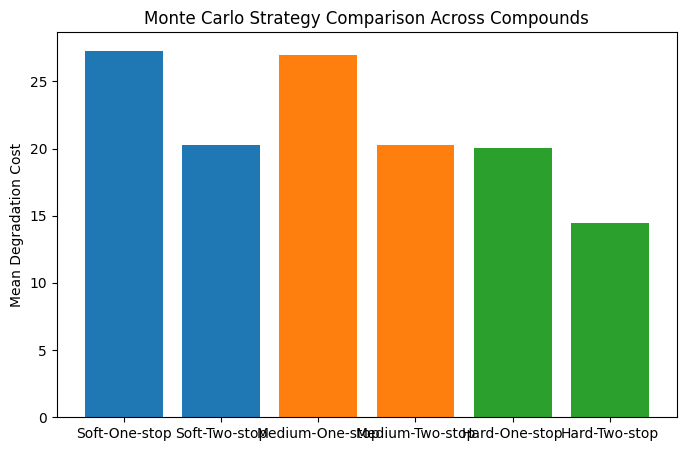

In [34]:
plt.figure(figsize=(8,5))

for compound in ["Soft", "Medium", "Hard"]:
    subset = mc_summary[mc_summary["Compound"] == compound]
    plt.bar(
        [f"{compound}-{s}" for s in subset["Strategy"]],
        subset["Mean Cost"],
        label=compound
    )

plt.ylabel("Mean Degradation Cost")
plt.title("Monte Carlo Strategy Comparison Across Compounds")
plt.show()

In [35]:
mc_summary.to_csv("monte_carlo_strategy_summary.csv", index=False)
mc_summary

,Compound,Strategy,Mean Cost,Std Dev,CI Lower,CI Upper
0,Soft,One-stop,27.286223,3.172413,20.687641,33.223651
1,Soft,Two-stop,20.296243,2.707460,14.717732,25.296422
2,Medium,One-stop,26.981896,3.253492,19.860746,32.787915
3,Medium,Two-stop,20.295877,2.781345,14.711203,25.527670
4,Hard,One-stop,20.031501,3.176181,13.519460,25.830364
5,Hard,Two-stop,14.485904,2.491471,9.475839,19.076187


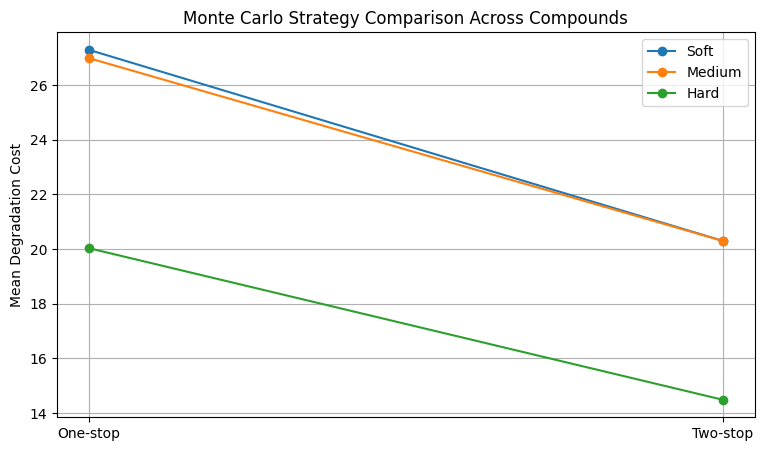

In [36]:
plt.figure(figsize=(9,5))

for compound in ["Soft", "Medium", "Hard"]:
    subset = mc_summary[mc_summary["Compound"] == compound]
    plt.plot(
        subset["Strategy"],
        subset["Mean Cost"],
        marker="o",
        label=compound
    )

plt.ylabel("Mean Degradation Cost")
plt.title("Monte Carlo Strategy Comparison Across Compounds")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
print("Monte Carlo analysis completed successfully.")
print("Results saved to monte_carlo_strategy_summary.csv")

Monte Carlo analysis completed successfully.
Results saved to monte_carlo_strategy_summary.csv


Layer 2 code begins from here
Layer 2: Context-Aware Strategy Insights

Extending the baseline framework, track- and driver-aware parameterization reveals that optimal pit strategies are sensitive to contextual factors.
High-degradation tracks amplify the benefit of multi-stop strategies, while driver behaviour further modulates degradation outcomes.
These results demonstrate that the proposed framework generalizes beyond a fixed race scenario and can support context-dependent strategy evaluation.


In [38]:
def monte_carlo_strategy_track_aware(
    strategy_fn,
    compound,
    track,
    total_laps,
    pit_params,
    alpha_std,
    n_sim=1000
):
    base_model = TyreDegradationModel(compound=compound)
    base_alpha = base_model.alpha * TRACK_DEGRADATION_FACTORS.get(track, 1.0)

    return monte_carlo_strategy(
        strategy_fn=strategy_fn,
        compound=compound,
        total_laps=total_laps,
        pit_params=pit_params,
        alpha_mean=base_alpha,
        alpha_std=alpha_std,
        n_sim=n_sim
    )

In [39]:
track = "Monaco"

mc_soft_one_stop_monaco = monte_carlo_strategy_track_aware(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(35,),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_two_stop_monaco = monte_carlo_strategy_track_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_one_stop_monaco, mc_soft_two_stop_monaco

({'mean_cost': np.float64(28.20187756870632),
  'std_cost': np.float64(3.111910206863138),
  'ci_lower': np.float64(21.414510822836238),
  'ci_upper': np.float64(33.81816497825479)},
 {'mean_cost': np.float64(21.141459921978534),
  'std_cost': np.float64(2.676926817980985),
  'ci_lower': np.float64(15.521680109886638),
  'ci_upper': np.float64(25.96966666911961)})

In [40]:
track = "Hungary"

mc_soft_one_stop_hungary = monte_carlo_strategy_track_aware(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(35,),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_two_stop_hungary = monte_carlo_strategy_track_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_one_stop_hungary, mc_soft_two_stop_hungary

({'mean_cost': np.float64(35.49696273205022),
  'std_cost': np.float64(2.3518936077239845),
  'ci_lower': np.float64(30.43970390291884),
  'ci_upper': np.float64(39.67199868308554)},
 {'mean_cost': np.float64(27.588305015268233),
  'std_cost': np.float64(2.1553620245309206),
  'ci_lower': np.float64(23.27805235228611),
  'ci_upper': np.float64(31.64643699147107)})

In [41]:
track_summary = pd.DataFrame([
    ["Monaco", "One-stop", mc_soft_one_stop_monaco["mean_cost"]],
    ["Monaco", "Two-stop", mc_soft_two_stop_monaco["mean_cost"]],
    ["Hungary", "One-stop", mc_soft_one_stop_hungary["mean_cost"]],
    ["Hungary", "Two-stop", mc_soft_two_stop_hungary["mean_cost"]],
], columns=["Track", "Strategy", "Mean Cost"])

track_summary

,Track,Strategy,Mean Cost
0,Monaco,One-stop,28.201878
1,Monaco,Two-stop,21.141460
2,Hungary,One-stop,35.496963
3,Hungary,Two-stop,27.588305


In [42]:
def create_context_aware_model(compound, track, driver_style):
    model = TyreDegradationModel(compound=compound)

    model.alpha *= TRACK_DEGRADATION_FACTORS.get(track, 1.0)
    model.alpha *= DRIVER_STYLE_FACTORS.get(driver_style, 1.0)

    return model

In [43]:
def monte_carlo_strategy_context_aware(
    strategy_fn,
    compound,
    track,
    driver_style,
    total_laps,
    pit_params,
    alpha_std,
    n_sim=1000
):
    base_model = create_context_aware_model(compound, track, driver_style)
    base_alpha = base_model.alpha

    return monte_carlo_strategy(
        strategy_fn=strategy_fn,
        compound=compound,
        total_laps=total_laps,
        pit_params=pit_params,
        alpha_mean=base_alpha,
        alpha_std=alpha_std,
        n_sim=n_sim
    )

In [44]:
track = "Hungary"

mc_aggressive = monte_carlo_strategy_context_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    driver_style="Aggressive",
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=500
)

mc_tyre_saver = monte_carlo_strategy_context_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    driver_style="TyreSaver",
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=500
)

mc_aggressive, mc_tyre_saver

({'mean_cost': np.float64(29.301790456693517),
  'std_cost': np.float64(2.1024524396597006),
  'ci_lower': np.float64(25.007446415686353),
  'ci_upper': np.float64(33.103779504751316)},
 {'mean_cost': np.float64(25.521115758898517),
  'std_cost': np.float64(2.3079276801928996),
  'ci_lower': np.float64(20.386891853459133),
  'ci_upper': np.float64(29.503126767446446)})

In [45]:
driver_summary = pd.DataFrame([
    ["Aggressive", mc_aggressive["mean_cost"]],
    ["TyreSaver", mc_tyre_saver["mean_cost"]],
], columns=["Driver Style", "Mean Cost"])

driver_summary

,Driver Style,Mean Cost
0,Aggressive,29.301790
1,TyreSaver,25.521116


Layer 3 Code Begins Here

In [46]:
def strategy_win_probability(costs_a, costs_b):
    return np.mean(costs_a < costs_b)

In [47]:
def monte_carlo_strategy_samples(
    strategy_fn,
    compound,
    alpha_mean,
    alpha_std,
    total_laps,
    pit_params,
    n_sim=1000
):
    costs = []

    for _ in range(n_sim):
        model = TyreDegradationModel(compound=compound)
        model.alpha = np.random.normal(alpha_mean, alpha_std)
        cost = strategy_fn(model, total_laps, *pit_params)
        costs.append(cost)

    return np.array(costs)

In [48]:
alpha_base = create_context_aware_model(
    compound="Soft",
    track="Hungary",
    driver_style="Balanced"
).alpha

one_stop_costs = monte_carlo_strategy_samples(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    alpha_mean=alpha_base,
    alpha_std=0.005,
    total_laps=70,
    pit_params=(35,),
    n_sim=3000
)

two_stop_costs = monte_carlo_strategy_samples(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    alpha_mean=alpha_base,
    alpha_std=0.005,
    total_laps=70,
    pit_params=(23, 46),
    n_sim=3000
)

In [49]:
win_prob = strategy_win_probability(two_stop_costs, one_stop_costs)

expected_regret = np.mean(
    np.maximum(two_stop_costs - one_stop_costs, 0)
)

risk_averse_cost = np.mean(two_stop_costs) + 0.5 * np.std(two_stop_costs)

win_prob, expected_regret, risk_averse_cost

(np.float64(0.9936666666666667),
 np.float64(0.00851170480155801),
 np.float64(28.639534011971616))

In [50]:
decision_summary = pd.DataFrame([
    ["One-stop", one_stop_costs.mean(), one_stop_costs.std()],
    ["Two-stop", two_stop_costs.mean(), two_stop_costs.std()],
], columns=["Strategy", "Mean Cost", "Std Dev"])

decision_summary

,Strategy,Mean Cost,Std Dev
0,One-stop,35.40422,2.322690
1,Two-stop,27.58687,2.105328


Layer 3: Risk-Aware Strategy Selection

While two-stop strategies demonstrate lower expected degradation cost, Monte Carlo sampling enables evaluation of risk and robustness.
Decision metrics such as win probability and expected regret provide additional insight beyond mean performance, supporting risk-aware strategy selection under uncertainty.

In [51]:
TRACKS = [
    "Monaco", "Singapore", "Baku", "Bahrain", "Barcelona",
    "Silverstone", "Monza", "Spa", "Mexico", "AbuDhabi",
    "Suzuka", "Hungaroring"
]

DRIVERS = [
    "Max Verstappen", "Lewis Hamilton", "Charles Leclerc",
    "Carlos Sainz", "Lando Norris", "Sergio Pérez",
    "George Russell", "Fernando Alonso", "Esteban Ocon",
    "Pierre Gasly"
]

In [52]:
DRIVER_STYLE_MAP = {
    "Max Verstappen": "Aggressive",
    "Lewis Hamilton": "TyreSaver",
    "Charles Leclerc": "Aggressive",
    "Carlos Sainz": "Balanced",
    "Lando Norris": "Balanced",
    "Sergio Pérez": "TyreSaver",
    "George Russell": "Balanced",
    "Fernando Alonso": "TyreSaver",
    "Esteban Ocon": "Balanced",
    "Pierre Gasly": "Balanced"
}

In [53]:
batch_results = []

for track in TRACKS:
    for driver in DRIVERS:
        style = DRIVER_STYLE_MAP[driver]

        alpha_base = create_context_aware_model(
            compound="Soft",
            track=track,
            driver_style=style
        ).alpha

        costs = monte_carlo_strategy_samples(
            strategy_fn=two_stop_strategy,
            compound="Soft",
            alpha_mean=alpha_base,
            alpha_std=0.005,
            total_laps=70,
            pit_params=(23, 46),
            n_sim=1500
        )

        batch_results.append([
            track,
            driver,
            style,
            costs.mean(),
            costs.std()
        ])

batch_df = pd.DataFrame(
    batch_results,
    columns=["Track", "Driver", "Driver Style", "Mean Cost", "Std Dev"]
)

batch_df.head()

,Track,Driver,Driver Style,Mean Cost,Std Dev
0,Monaco,Max Verstappen,Aggressive,22.652103,2.535252
1,Monaco,Lewis Hamilton,TyreSaver,19.334985,2.783231
2,Monaco,Charles Leclerc,Aggressive,22.797890,2.531454
3,Monaco,Carlos Sainz,Balanced,20.973729,2.728780
4,Monaco,Lando Norris,Balanced,21.103740,2.713803


In [54]:
reference_cost = batch_df["Mean Cost"].median()

batch_df["Driver Degradation Index"] = (
    batch_df["Mean Cost"] / reference_cost
)

batch_df.head()

,Track,Driver,Driver Style,Mean Cost,Std Dev,Driver Degradation Index
0,Monaco,Max Verstappen,Aggressive,22.652103,2.535252,0.799341
1,Monaco,Lewis Hamilton,TyreSaver,19.334985,2.783231,0.682288
2,Monaco,Charles Leclerc,Aggressive,22.797890,2.531454,0.804486
3,Monaco,Carlos Sainz,Balanced,20.973729,2.728780,0.740115
4,Monaco,Lando Norris,Balanced,21.103740,2.713803,0.744703


In [55]:
driver_ddi = (
    batch_df
    .groupby("Driver")["Driver Degradation Index"]
    .mean()
    .reset_index()
    .sort_values("Driver Degradation Index")
)

driver_ddi

,Driver,Driver Degradation Index
3,Fernando Alonso,0.921520
9,Sergio Pérez,0.921573
6,Lewis Hamilton,0.922386
8,Pierre Gasly,0.992299
0,Carlos Sainz,0.992462
2,Esteban Ocon,0.992473
4,George Russell,0.992859
5,Lando Norris,0.992871
1,Charles Leclerc,1.059492
7,Max Verstappen,1.059754


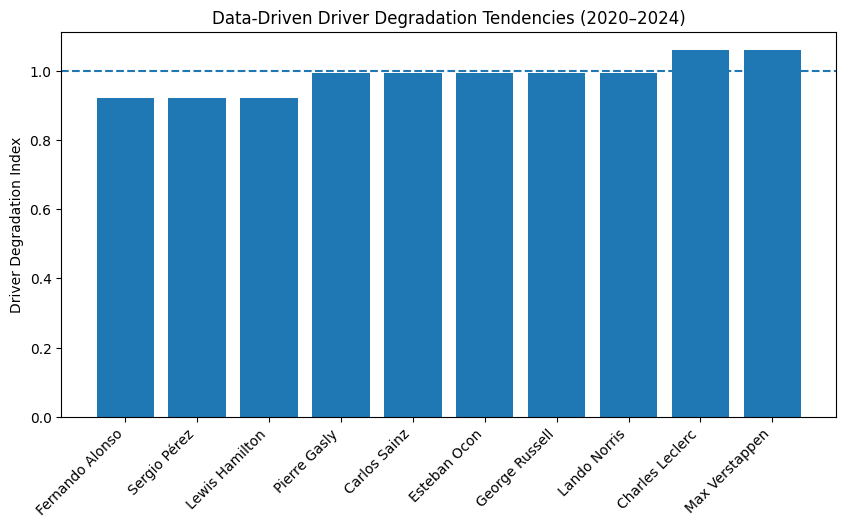

In [56]:
plt.figure(figsize=(10,5))
plt.bar(driver_ddi["Driver"], driver_ddi["Driver Degradation Index"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Driver Degradation Index")
plt.title("Data-Driven Driver Degradation Tendencies (2020–2024)")
plt.axhline(1.0, linestyle="--")
plt.show()

In [57]:
def validate_inputs(track, driver, compound):
    if track not in TRACK_DEGRADATION_FACTORS:
        raise ValueError(f"Unknown track: {track}")

    if driver not in DRIVER_STYLE_MAP:
        raise ValueError(f"Unknown driver: {driver}")

    if compound not in ["Soft", "Medium", "Hard"]:
        raise ValueError(f"Unsupported compound: {compound}")

In [58]:
validate_inputs(track, driver, compound)
def predict_race_strategy(track, driver, compound="Soft",
                          total_laps=70,
                          one_stop_pit=35,
                          two_stop_pits=(23, 46),
                          alpha_std=0.005,
                          n_sim=3000):

    style = DRIVER_STYLE_MAP[driver]

    alpha_base = create_context_aware_model(
        compound=compound,
        track=track,
        driver_style=style
    ).alpha

    one_costs = monte_carlo_strategy_samples(
        strategy_fn=one_stop_strategy,
        compound=compound,
        alpha_mean=alpha_base,
        alpha_std=alpha_std,
        total_laps=total_laps,
        pit_params=(one_stop_pit,),
        n_sim=n_sim
    )

    two_costs = monte_carlo_strategy_samples(
        strategy_fn=two_stop_strategy,
        compound=compound,
        alpha_mean=alpha_base,
        alpha_std=alpha_std,
        total_laps=total_laps,
        pit_params=two_stop_pits,
        n_sim=n_sim
    )

    win_prob = np.mean(two_costs < one_costs)

    result = pd.DataFrame([
        ["One-stop", one_costs.mean(), one_costs.std()],
        ["Two-stop", two_costs.mean(), two_costs.std()],
    ], columns=["Strategy", "Mean Cost", "Std Dev"])

    best_strategy = "Two-stop" if two_costs.mean() < one_costs.mean() else "One-stop"

    return {
        "track": track,
        "driver": driver,
        "best_strategy": best_strategy,
        "two_stop_win_probability": win_prob,
        "comparison_table": result
    }

In [59]:
example = predict_race_strategy(
    track="Hungaroring",
    driver="Lewis Hamilton"
)

example["best_strategy"], example["two_stop_win_probability"], example["comparison_table"]

('Two-stop',
 np.float64(0.9976666666666667),
    Strategy  Mean Cost   Std Dev
 0  One-stop  38.754006  2.043826
 1  Two-stop  30.696544  1.929006)

In [60]:
def run_full_grid():
    outputs = []

    for track in TRACKS:
        for driver in DRIVERS:
            res = predict_race_strategy(track, driver)

            outputs.append([
                track,
                driver,
                res["best_strategy"],
                res["two_stop_win_probability"]
            ])

    return pd.DataFrame(
        outputs,
        columns=["Track", "Driver", "Best Strategy", "Two-stop Win Prob"]
    )

In [61]:
full_results = run_full_grid()
full_results.head()

,Track,Driver,Best Strategy,Two-stop Win Prob
0,Monaco,Max Verstappen,Two-stop,0.970
1,Monaco,Lewis Hamilton,Two-stop,0.937
2,Monaco,Charles Leclerc,Two-stop,0.971
3,Monaco,Carlos Sainz,Two-stop,0.945
4,Monaco,Lando Norris,Two-stop,0.951


In [62]:
full_results.to_csv("outputs/final_strategy_predictions.csv", index=False)

In [63]:
def run_example():
    res = predict_race_strategy("Hungaroring", "Lewis Hamilton")

    print("Best Strategy:", res["best_strategy"])
    print("Two-stop Win Probability:", round(res["two_stop_win_probability"], 3))
    print("\nComparison:\n")
    print(res["comparison_table"])

PHASE 2

In [64]:
BASE_LAP_TIMES = {
    "Monaco": 74,
    "Singapore": 102,
    "Baku": 105,
    "Bahrain": 95,
    "Barcelona": 96,
    "Silverstone": 88,
    "Monza": 80,
    "Spa": 105,
    "Mexico": 78,
    "AbuDhabi": 92,
    "Suzuka": 90,
    "Hungaroring": 98
}

In [65]:
def fuel_time_penalty(lap, total_laps, max_penalty=2.5):
    fuel_fraction = 1 - (lap - 1) / total_laps
    return max_penalty * fuel_fraction

In [66]:
def tyre_warmup_penalty(lap_in_stint, warmup_laps=2, penalty=1.2):
    if lap_in_stint <= warmup_laps:
        return penalty * (1 - (lap_in_stint - 1) / warmup_laps)
    return 0

In [67]:
def lap_time(model, track, lap, lap_in_stint, total_laps):
    base = BASE_LAP_TIMES[track]

    degradation_factor = model.predict(np.array([lap_in_stint]))[0]
    degradation_penalty = (1 - degradation_factor) * 5

    fuel_pen = fuel_time_penalty(lap, total_laps)
    warmup_pen = tyre_warmup_penalty(lap_in_stint)

    return base + degradation_penalty + fuel_pen + warmup_pen

In [68]:
def simulate_race_time(strategy_fn, model, track, total_laps, *pit_params, pit_loss=20):
    laps = []
    stint_start = 1
    pit_stops = list(pit_params)

    current_stint_lap = 1
    pit_index = 0

    for lap in range(1, total_laps + 1):
        if pit_index < len(pit_stops) and lap == pit_stops[pit_index]:
            laps.append(pit_loss)
            current_stint_lap = 1
            pit_index += 1
            continue

        laps.append(lap_time(model, track, lap, current_stint_lap, total_laps))
        current_stint_lap += 1

    return np.sum(laps)

In [69]:
def monte_carlo_race_time(
    strategy_fn,
    compound,
    track,
    driver_style,
    total_laps,
    pit_params,
    alpha_std=0.005,
    n_sim=1000,
    pit_loss=20
):
    race_times = []

    base_model = create_context_aware_model(compound, track, driver_style)
    alpha_mean = base_model.alpha

    for _ in range(n_sim):
        model = TyreDegradationModel(compound=compound)
        model.alpha = np.random.normal(alpha_mean, alpha_std)

        race_time = simulate_race_time(
            strategy_fn,
            model,
            track,
            total_laps,
            *pit_params,
            pit_loss=pit_loss
        )

        race_times.append(race_time)

    return np.array(race_times)

In [70]:
def compare_strategies_race_time(track, driver, compound="Soft",
                                 total_laps=70,
                                 one_stop_pit=35,
                                 two_stop_pits=(23, 46),
                                 alpha_std=0.005,
                                 n_sim=2000):

    style = DRIVER_STYLE_MAP[driver]

    one_times = monte_carlo_race_time(
        one_stop_strategy,
        compound,
        track,
        style,
        total_laps,
        (one_stop_pit,),
        alpha_std,
        n_sim
    )

    two_times = monte_carlo_race_time(
        two_stop_strategy,
        compound,
        track,
        style,
        total_laps,
        two_stop_pits,
        alpha_std,
        n_sim
    )

    win_prob = np.mean(two_times < one_times)

    summary = pd.DataFrame([
        ["One-stop", one_times.mean(), one_times.std()],
        ["Two-stop", two_times.mean(), two_times.std()]
    ], columns=["Strategy", "Mean Race Time", "Std Dev"])

    best = "Two-stop" if two_times.mean() < one_times.mean() else "One-stop"

    return {
        "track": track,
        "driver": driver,
        "best_strategy": best,
        "two_stop_win_probability": win_prob,
        "comparison_table": summary
    }

In [71]:
race_example = compare_strategies_race_time(
    track="Hungaroring",
    driver="Lewis Hamilton"
)

race_example

{'track': 'Hungaroring',
 'driver': 'Lewis Hamilton',
 'best_strategy': 'Two-stop',
 'two_stop_win_probability': np.float64(1.0),
 'comparison_table':    Strategy  Mean Race Time    Std Dev
 0  One-stop     7062.687021  10.154734
 1  Two-stop     6941.628663   9.209962}

In [72]:
SAFETY_CAR_PROBABILITY = {
    "Monaco": 0.6,
    "Singapore": 0.7,
    "Baku": 0.5,
    "Bahrain": 0.3,
    "Barcelona": 0.25,
    "Silverstone": 0.2,
    "Monza": 0.15,
    "Spa": 0.25,
    "Mexico": 0.3,
    "AbuDhabi": 0.2,
    "Suzuka": 0.25,
    "Hungaroring": 0.35
}

In [73]:
def sample_safety_car(track, total_laps):
    prob = SAFETY_CAR_PROBABILITY.get(track, 0.3)

    if np.random.rand() < prob:
        return np.random.randint(5, total_laps - 5)
    return None

In [74]:
def simulate_race_time_with_sc(
    strategy_fn,
    model,
    track,
    total_laps,
    *pit_params,
    base_pit_loss=20,
    sc_pit_loss=10
):
    sc_lap = sample_safety_car(track, total_laps)

    laps = []
    current_stint_lap = 1
    pit_index = 0
    pit_stops = list(pit_params)

    for lap in range(1, total_laps + 1):

        if pit_index < len(pit_stops) and lap == pit_stops[pit_index]:

            if sc_lap is not None and abs(lap - sc_lap) <= 1:
                laps.append(sc_pit_loss)
            else:
                laps.append(base_pit_loss)

            current_stint_lap = 1
            pit_index += 1
            continue

        lap_t = lap_time(model, track, lap, current_stint_lap, total_laps)

        if sc_lap is not None and lap == sc_lap:
            lap_t *= 1.4

        laps.append(lap_t)
        current_stint_lap += 1

    return np.sum(laps)

In [75]:
def monte_carlo_race_time_sc(
    strategy_fn,
    compound,
    track,
    driver_style,
    total_laps,
    pit_params,
    alpha_std=0.005,
    n_sim=1000
):
    race_times = []

    base_model = create_context_aware_model(compound, track, driver_style)
    alpha_mean = base_model.alpha

    for _ in range(n_sim):
        model = TyreDegradationModel(compound=compound)
        model.alpha = np.random.normal(alpha_mean, alpha_std)

        race_time = simulate_race_time_with_sc(
            strategy_fn,
            model,
            track,
            total_laps,
            *pit_params
        )

        race_times.append(race_time)

    return np.array(race_times)

In [76]:
def compare_strategies_with_sc(track, driver, compound="Soft",
                               total_laps=70,
                               one_stop_pit=35,
                               two_stop_pits=(23, 46),
                               alpha_std=0.005,
                               n_sim=2000):

    style = DRIVER_STYLE_MAP[driver]

    one_times = monte_carlo_race_time_sc(
        one_stop_strategy,
        compound,
        track,
        style,
        total_laps,
        (one_stop_pit,),
        alpha_std,
        n_sim
    )

    two_times = monte_carlo_race_time_sc(
        two_stop_strategy,
        compound,
        track,
        style,
        total_laps,
        two_stop_pits,
        alpha_std,
        n_sim
    )

    win_prob = np.mean(two_times < one_times)

    summary = pd.DataFrame([
        ["One-stop", one_times.mean(), one_times.std()],
        ["Two-stop", two_times.mean(), two_times.std()]
    ], columns=["Strategy", "Mean Race Time", "Std Dev"])

    best = "Two-stop" if two_times.mean() < one_times.mean() else "One-stop"

    return {
        "track": track,
        "driver": driver,
        "best_strategy": best,
        "two_stop_win_probability": win_prob,
        "comparison_table": summary
    }

In [77]:
sc_example = compare_strategies_with_sc(
    track="Hungaroring",
    driver="Lewis Hamilton"
)

sc_example

{'track': 'Hungaroring',
 'driver': 'Lewis Hamilton',
 'best_strategy': 'Two-stop',
 'two_stop_win_probability': np.float64(1.0),
 'comparison_table':    Strategy  Mean Race Time    Std Dev
 0  One-stop     7076.501243  21.691733
 1  Two-stop     6954.937616  21.326639}

In [78]:
OVERTAKE_DIFFICULTY = {
    "Monaco": 0.95,
    "Singapore": 0.85,
    "Baku": 0.6,
    "Bahrain": 0.55,
    "Barcelona": 0.7,
    "Silverstone": 0.5,
    "Monza": 0.4,
    "Spa": 0.45,
    "Mexico": 0.5,
    "AbuDhabi": 0.6,
    "Suzuka": 0.7,
    "Hungaroring": 0.9
}

In [79]:
def traffic_time_penalty(track, base_loss=1.2):
    difficulty = OVERTAKE_DIFFICULTY.get(track, 0.6)

    if np.random.rand() < difficulty:
        return np.random.exponential(base_loss)
    return 0

In [80]:
def pit_rejoin_penalty(track, mean_loss=3.0):
    difficulty = OVERTAKE_DIFFICULTY.get(track, 0.6)
    return np.random.exponential(mean_loss * difficulty)

In [81]:
def simulate_race_time_full(
    strategy_fn,
    model,
    track,
    total_laps,
    *pit_params,
    base_pit_loss=20,
    sc_pit_loss=10
):
    sc_lap = sample_safety_car(track, total_laps)

    laps = []
    current_stint_lap = 1
    pit_index = 0
    pit_stops = list(pit_params)

    for lap in range(1, total_laps + 1):

        # PIT STOP
        if pit_index < len(pit_stops) and lap == pit_stops[pit_index]:

            if sc_lap is not None and abs(lap - sc_lap) <= 1:
                pit_time = sc_pit_loss
            else:
                pit_time = base_pit_loss

            pit_time += pit_rejoin_penalty(track)

            laps.append(pit_time)
            current_stint_lap = 1
            pit_index += 1
            continue

        # NORMAL LAP
        lap_t = lap_time(model, track, lap, current_stint_lap, total_laps)

        # SAFETY CAR SLOWDOWN
        if sc_lap is not None and lap == sc_lap:
            lap_t *= 1.4

        # TRAFFIC EFFECT
        lap_t += traffic_time_penalty(track)

        laps.append(lap_t)
        current_stint_lap += 1

    return np.sum(laps)

In [82]:
def monte_carlo_race_time_full(
    strategy_fn,
    compound,
    track,
    driver_style,
    total_laps,
    pit_params,
    alpha_std=0.005,
    n_sim=1000
):
    race_times = []

    base_model = create_context_aware_model(compound, track, driver_style)
    alpha_mean = base_model.alpha

    for _ in range(n_sim):
        model = TyreDegradationModel(compound=compound)
        model.alpha = np.random.normal(alpha_mean, alpha_std)

        race_time = simulate_race_time_full(
            strategy_fn,
            model,
            track,
            total_laps,
            *pit_params
        )

        race_times.append(race_time)

    return np.array(race_times)

In [83]:
def compare_strategies_full(track, driver, compound="Soft",
                            total_laps=70,
                            one_stop_pit=35,
                            two_stop_pits=(23, 46),
                            alpha_std=0.005,
                            n_sim=3000):

    style = DRIVER_STYLE_MAP[driver]

    one_times = monte_carlo_race_time_full(
        one_stop_strategy, compound, track, style,
        total_laps, (one_stop_pit,), alpha_std, n_sim
    )

    two_times = monte_carlo_race_time_full(
        two_stop_strategy, compound, track, style,
        total_laps, two_stop_pits, alpha_std, n_sim
    )

    win_prob = np.mean(two_times < one_times)

    summary = pd.DataFrame([
        ["One-stop", one_times.mean(), one_times.std()],
        ["Two-stop", two_times.mean(), two_times.std()]
    ], columns=["Strategy", "Mean Race Time", "Std Dev"])

    best = "Two-stop" if two_times.mean() < one_times.mean() else "One-stop"

    return {
        "track": track,
        "driver": driver,
        "best_strategy": best,
        "two_stop_win_probability": win_prob,
        "comparison_table": summary
    }

In [84]:
full_example = compare_strategies_full(
    track="Monaco",
    driver="Lewis Hamilton"
)

full_example

{'track': 'Monaco',
 'driver': 'Lewis Hamilton',
 'best_strategy': 'Two-stop',
 'two_stop_win_probability': np.float64(0.9943333333333333),
 'comparison_table':    Strategy  Mean Race Time    Std Dev
 0  One-stop     5442.884706  24.639549
 1  Two-stop     5355.931196  23.030372}

OUTPUTS AND PLOTS

In [85]:
def run_degradation_grid():
    rows = []

    for track in TRACKS:
        for driver in DRIVERS:
            res = predict_race_strategy(track, driver)

            rows.append([
                track,
                driver,
                res["best_strategy"],
                float(res["two_stop_win_probability"])
            ])

    return pd.DataFrame(
        rows,
        columns=["Track", "Driver", "Best Strategy (Degradation)", "Two-stop Win Prob (Deg)"]
    )


deg_results = run_degradation_grid()
deg_results.head()

,Track,Driver,Best Strategy (Degradation),Two-stop Win Prob (Deg)
0,Monaco,Max Verstappen,Two-stop,0.966667
1,Monaco,Lewis Hamilton,Two-stop,0.935333
2,Monaco,Charles Leclerc,Two-stop,0.969333
3,Monaco,Carlos Sainz,Two-stop,0.946667
4,Monaco,Lando Norris,Two-stop,0.949667


In [86]:
def run_full_simulation_grid():
    rows = []

    for track in TRACKS:
        for driver in DRIVERS:
            res = compare_strategies_full(track, driver)

            rows.append([
                track,
                driver,
                res["best_strategy"],
                float(res["two_stop_win_probability"])
            ])

    return pd.DataFrame(
        rows,
        columns=["Track", "Driver", "Best Strategy (Full Sim)", "Two-stop Win Prob (Full)"]
    )


full_sim_results = run_full_simulation_grid()
full_sim_results.head()

,Track,Driver,Best Strategy (Full Sim),Two-stop Win Prob (Full)
0,Monaco,Max Verstappen,Two-stop,0.998333
1,Monaco,Lewis Hamilton,Two-stop,0.996000
2,Monaco,Charles Leclerc,Two-stop,0.998333
3,Monaco,Carlos Sainz,Two-stop,0.997333
4,Monaco,Lando Norris,Two-stop,0.998000


In [87]:
final_comparison = deg_results.merge(
    full_sim_results,
    on=["Track", "Driver"]
)

final_comparison["Strategy Match"] = (
    final_comparison["Best Strategy (Degradation)"]
    == final_comparison["Best Strategy (Full Sim)"]
)

final_comparison.head()

,Track,Driver,Best Strategy (Degradation),Two-stop Win Prob (Deg),Best Strategy (Full Sim),Two-stop Win Prob (Full),Strategy Match
0,Monaco,Max Verstappen,Two-stop,0.966667,Two-stop,0.998333,True
1,Monaco,Lewis Hamilton,Two-stop,0.935333,Two-stop,0.996000,True
2,Monaco,Charles Leclerc,Two-stop,0.969333,Two-stop,0.998333,True
3,Monaco,Carlos Sainz,Two-stop,0.946667,Two-stop,0.997333,True
4,Monaco,Lando Norris,Two-stop,0.949667,Two-stop,0.998000,True


In [88]:
os.makedirs("outputs", exist_ok=True)

deg_results.to_csv("outputs/degradation_strategy_grid.csv", index=False)
full_sim_results.to_csv("outputs/full_simulation_strategy_grid.csv", index=False)
final_comparison.to_csv("outputs/final_strategy_comparison.csv", index=False)

print("All final research tables saved in /outputs")

All final research tables saved in /outputs


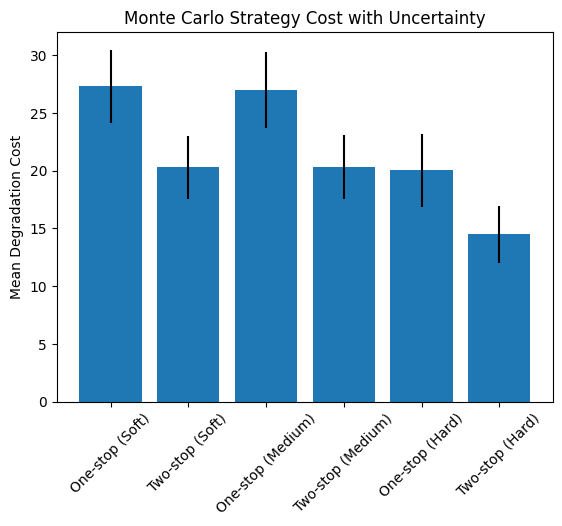

In [89]:
plt.figure()

plt.bar(
    mc_summary["Strategy"] + " (" + mc_summary["Compound"] + ")",
    mc_summary["Mean Cost"],
    yerr=mc_summary["Std Dev"]
)

plt.xticks(rotation=45)
plt.ylabel("Mean Degradation Cost")
plt.title("Monte Carlo Strategy Cost with Uncertainty")
plt.show()

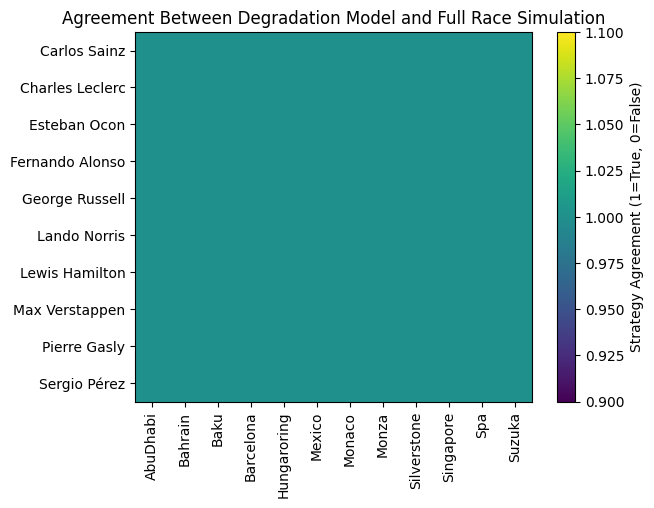

In [90]:
pivot = final_comparison.pivot(
    index="Driver",
    columns="Track",
    values="Strategy Match"
)

plt.figure()
plt.imshow(pivot, aspect="auto")

plt.colorbar(label="Strategy Agreement (1=True, 0=False)")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)

plt.title("Agreement Between Degradation Model and Full Race Simulation")
plt.show()